# Chapter 13: Deep neural network (DNN)

### 13.1. Intuition behind DNN
> ###### 13.1.1. Forward propagation
> ###### 13.1.2. Gradient descent
> ###### 13.1.3. Backpropagation

### 13.2. DDN for classification
> ###### 13.2.1. Preparation of data
> ###### 13.2.2. Implement a DNN for a classification task
> ###### 13.2.3. Prediction and backtest

### 13.3. DNN for regression
> ###### 13.3.1. Implement a DNN for a regression task
> ###### 13.3.2. Custom loss function
> ###### 13.3.3. Prediction and backtest

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from Backtest import *
np.random.seed(56)

### 13.2.1. Preparation of data 

In [2]:
# Import the data
df = yf.download("AAPL", end="2021-01-01")[["Adj Close"]].pct_change(1)
df.columns = ["returns"]

# Features engeeniring
df["returns t-1"] = df[["returns"]].shift(1)

# Mean of returns
df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)

# Volatility of returns
df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)

# Drop missing values
df = df.dropna()

# Percentage train set
split = int(0.80*len(df))

# Train set creation
X_train = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[:split]

y_train_reg = df[["returns"]].iloc[:split]

y_train_cla = np.round(df[["returns"]].iloc[:split]+0.5)


# Test set creation
X_test = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[split:]

y_test_reg = df[["returns"]].iloc[split:]
y_test_cla = np.round(df[["returns"]].iloc[split:]+0.5)


# NORMALIZATION 
# Import the class
from sklearn.preprocessing import StandardScaler

# Initialize the class
sc = StandardScaler()

# Standardize the data
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

[*********************100%***********************]  1 of 1 completed


### 13.2.2. Implement a DNN for a classification task

In [3]:
np.random.seed(15)
# LIBAIRIES
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

nb_hidden_layer = 1


# INTIALIZATION SEQUENTIAL MODEL
classifier = Sequential()

# AJOUT COUCHE DENSE ET DROPOUT
for _ in range(nb_hidden_layer):
    classifier.add(Dense(75, input_shape = (X_train.shape[1],), activation="relu"))


# AJOUT COUCHE DENSE
classifier.add(Dense(1, activation="sigmoid"))

# COMPILATION DU MODÈLE
classifier.compile(loss="binary_crossentropy", optimizer="adam")

# TRAINING
classifier.fit(X_train_scaled, y_train_cla, epochs=15, batch_size=150, verbose=1)

Epoch 1/15
54/54 [==============================] - 1s 1ms/step - loss: 0.7005
Epoch 2/15
54/54 [==============================] - 0s 922us/step - loss: 0.6934
Epoch 3/15
54/54 [==============================] - 0s 903us/step - loss: 0.6928
Epoch 4/15
54/54 [==============================] - 0s 866us/step - loss: 0.6906
Epoch 5/15
54/54 [==============================] - 0s 866us/step - loss: 0.6917
Epoch 6/15
54/54 [==============================] - 0s 884us/step - loss: 0.6905
Epoch 7/15
54/54 [==============================] - 0s 847us/step - loss: 0.6908
Epoch 8/15
54/54 [==============================] - 0s 847us/step - loss: 0.6897
Epoch 9/15
54/54 [==============================] - 0s 847us/step - loss: 0.6898
Epoch 10/15
54/54 [==============================] - 0s 809us/step - loss: 0.6894
Epoch 11/15
54/54 [==============================] - 0s 1ms/step - loss: 0.6891
Epoch 12/15
54/54 [==============================] - 0s 1ms/step - loss: 0.6902
Epoch 13/15
54/54 [============

### 13.2.3. Predictions and backtest

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.23 	 Alpha: 17.49 %	     Sharpe: 0.594 	 Sortino: 0.841
  -----------------------------------------------------------------------------
    VaR: 84.73 %	 cVaR: 100.5 % 	     VaR/cVaR: 1.186 	 drawdown: 81.8 %
  -----------------------------------------------------------------------------


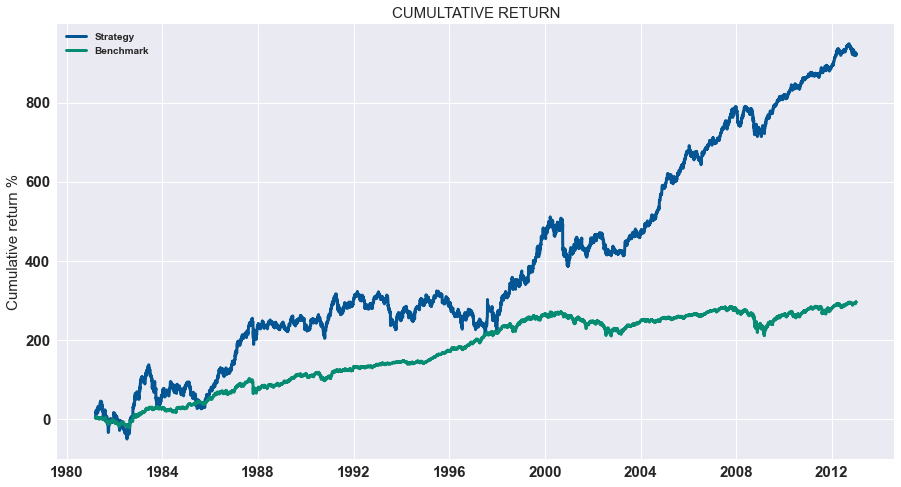

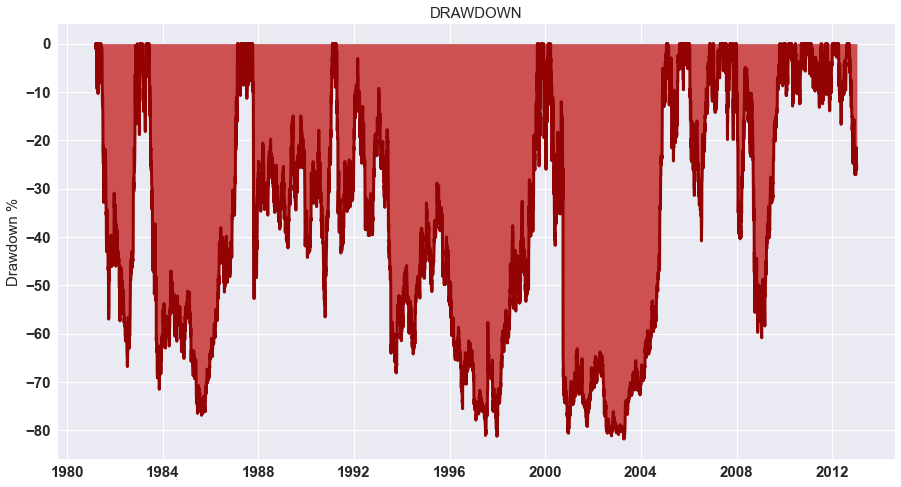

In [4]:
# Create predictions for the whole dataset
df["prediction"] = classifier.predict(np.concatenate((X_train,X_test),
                                    axis=0))
df["prediction"] = np.where(df["prediction"] == 0, -1,1)
# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[:split])

### 13.3.1. Implement a DNN for a regression task¶

In [5]:
np.random.seed(15)# LIBAIRIES
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

nb_hidden_layer = 1


# INTIALIZATION SEQUENTIAL MODEL
regressor = Sequential()

# ADD HIDDEN LAYER
for _ in range(nb_hidden_layer):
    regressor.add(Dense(75, input_shape = (X_train.shape[1],), activation="relu"))


# OUTPUT LAYER DENSE
regressor.add(Dense(1, activation="linear"))

# COMPILE THE MODEL
regressor.compile(loss="mse", optimizer="adam")

# TRAINING
regressor.fit(X_train_scaled, y_train_reg, epochs=13, batch_size=32, verbose=1)

Epoch 1/13
251/251 [==============================] - 0s 774us/step - loss: 0.0264
Epoch 2/13
251/251 [==============================] - 0s 738us/step - loss: 0.0015
Epoch 3/13
251/251 [==============================] - 0s 754us/step - loss: 0.0013
Epoch 4/13
251/251 [==============================] - 0s 862us/step - loss: 0.0011
Epoch 5/13
251/251 [==============================] - 0s 702us/step - loss: 0.0012
Epoch 6/13
251/251 [==============================] - 0s 694us/step - loss: 0.0011
Epoch 7/13
251/251 [==============================] - 0s 682us/step - loss: 0.0011
Epoch 8/13
251/251 [==============================] - 0s 678us/step - loss: 0.0010
Epoch 9/13
251/251 [==============================] - 0s 722us/step - loss: 0.0012
Epoch 10/13
251/251 [==============================] - 0s 718us/step - loss: 0.0010
Epoch 11/13
251/251 [==============================] - 0s 666us/step - loss: 0.0011
Epoch 12/13
251/251 [==============================] - 0s 734us/step - loss: 0.0012
E

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.417 	 Alpha: 11.52 %	     Sharpe: 0.595 	 Sortino: 0.886
  -----------------------------------------------------------------------------
    VaR: 49.84 %	 cVaR: 59.13 % 	     VaR/cVaR: 1.186 	 drawdown: 63.95 %
  -----------------------------------------------------------------------------


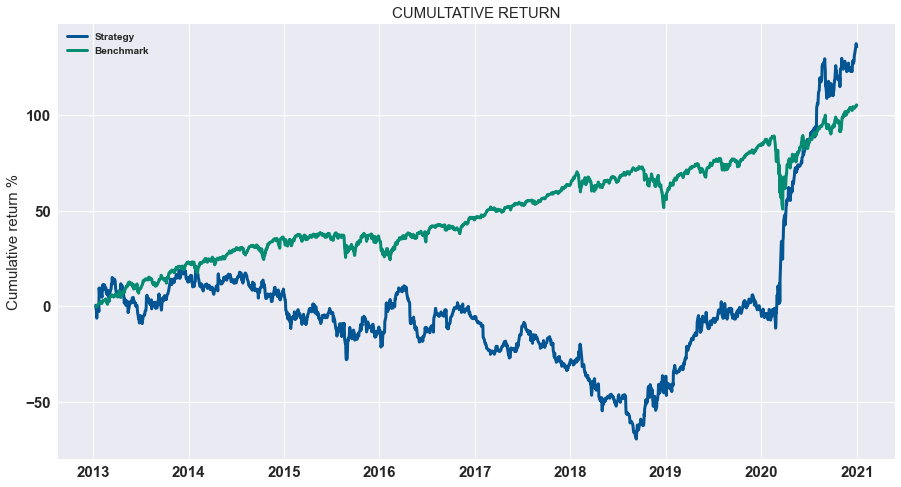

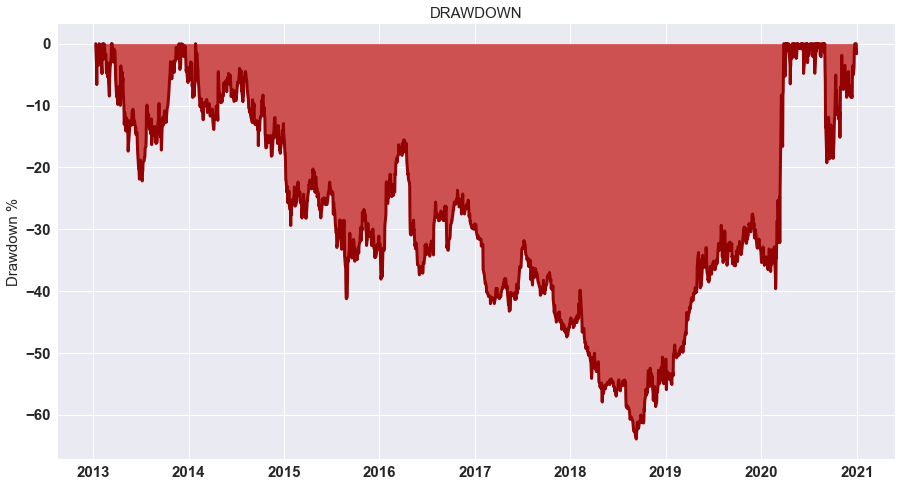

In [6]:
# Create predictions for the whole dataset
df["prediction"] = regressor.predict(np.concatenate((X_train,X_test),
                                    axis=0))

# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.backend as F

def ALPHA_MSE(y_true, y_pred):
    y_true_roll = tf.roll(y_true, shift=1, axis=0)
    y_pred_roll = tf.roll(y_pred, shift=1, axis=0)
    y_true_dif = tf.math.sign(y_true_roll-y_true)
    y_pred_dif = tf.math.sign(y_pred_roll-y_pred)
    booleen_vector = y_true_dif == y_pred_dif
    alpha = tf.where(booleen_vector, 1, 3)
    alpha = tf.cast(alpha, dtype=tf.float32)
    mse = F.square(y_true-y_pred)
    mse = tf.cast(mse, dtype=tf.float32)
    scale_mse = tf.multiply(alpha, mse)
    alpha_mse = F.mean(scale_mse)
    return alpha_mse

Epoch 1/13
251/251 [==============================] - 1s 1ms/step - loss: 0.0141
Epoch 2/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 3/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 4/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 5/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 6/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 7/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 8/13
251/251 [==============================] - 0s 993us/step - loss: 0.0020
Epoch 9/13
251/251 [==============================] - 0s 882us/step - loss: 0.0018
Epoch 10/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 11/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 12/13
251/251 [==============================] - 0s 989us/step - loss: 0.0017
Epoch 13/13
251/251

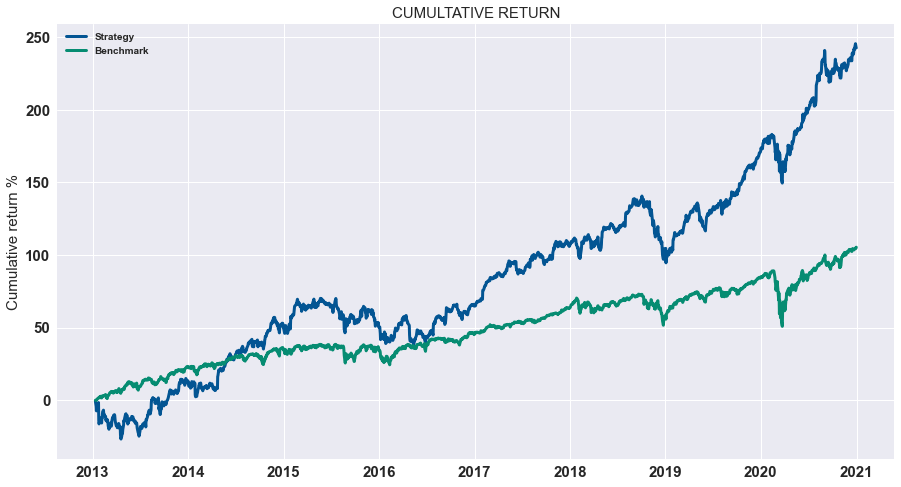

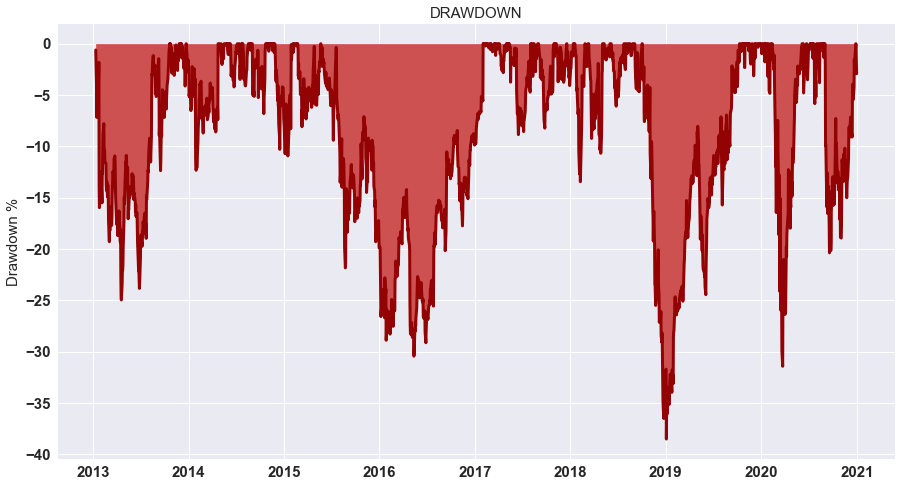

In [11]:
# LIBAIRIES
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

nb_hidden_layer = 3

np.random.seed(15)
# INTIALIZATION SEQUENTIAL MODEL
regressor = Sequential()

# AJOUT COUCHE DENSE ET DROPOUT
for _ in range(nb_hidden_layer):
    regressor.add(Dense(75, input_shape = (X_train.shape[1],), activation="relu"))


# AJOUT COUCHE DENSE
regressor.add(Dense(1, activation="linear"))

# COMPILATION DU MODÈLE
regressor.compile(loss=ALPHA_MSE, optimizer="adam")

regressor.fit(X_train_scaled, y_train_reg, epochs=13, batch_size=32, verbose=1)

# Create predictions for the whole dataset
df["prediction"] = regressor.predict(np.concatenate((X_train,X_test),
                                    axis=0))

# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
from Backtest import *
backtest_dynamic_portfolio(df["strategy"].iloc[split:])